In [721]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.font_manager import FontProperties
import jieba
jieba.set_dictionary("dict.txt")
import string
import re
import networkx as nx
import matplotlib

# Import Data

In [722]:
# import data from csv
file_name = ['淘寶.xlsx', '蝦皮.xlsx', 'PChome.xlsx']
Toa_raw, shopee_raw, PChome_raw = (pd.read_excel(i,encoding='utf-8') for i in file_name)
all_data= [Toa_raw, shopee_raw, PChome_raw]
name=['淘寶', '蝦皮','PChome']
# basic info
def print_format(listOfThree):
    name=['淘寶', '蝦皮','PChome']
    for i in range(3):
        print('%s: %s'%(name[i], listOfThree[i]))
        
columns = [i.columns.values for i in all_data]
timePeriod = [(min(i['發佈時間']), max(i['發佈時間'])) for i in all_data]
print_format(columns)
print_format(timePeriod)
shopee_norm = shopee_raw.drop(np.setdiff1d(columns[1], columns[0]),axis=1)
################# Use this
all_data= [Toa_raw, shopee_norm, PChome_raw]

淘寶: ['標題' '內容' '來源' '來源網站' '主文/回文' '發佈時間' '討論串總則數' '點閱數' '分享/轉貼數' '作者' '正面強度'
 '負面強度' '情緒標記' '原始連結']
蝦皮: ['標題' '內容' '產品/賣家討論' '電商平台討論' '平台使用討論' '抽獎留言' '社群互動' '優惠分享' '來源' '來源網站'
 '主文/回文' '發佈時間' '討論串總則數' '點閱數' '分享/轉貼數' '作者' '正面強度' '負面強度' '情緒標記' '原始連結']
PChome: ['標題' '內容' '來源' '來源網站' '主文/回文' '發佈時間' '討論串總則數' '點閱數' '分享/轉貼數' '作者' '正面強度'
 '負面強度' '情緒標記' '原始連結']
淘寶: ('2018/01/06 02:26:01', '2018/03/06 23:45:59')
蝦皮: ('2018/01/12 21:02:00', '2018/03/05 19:51:47')
PChome: ('2018/01/06 00:19:26', '2018/03/06 01:46:30')


In [723]:
# Chk if there's any dup title between three files
title_count=[i.drop_duplicates(subset=['標題']).size for i in all_data]
allCat = all_data[0].append([all_data[1], all_data[2]], ignore_index = True)
print('dup title count: %s' % (sum(title_count) - allCat.drop_duplicates(subset=['標題']).size, ))

dup title count: 28


In [724]:
#print([i.size for i in all_data])
#print(allCat.size)

# dedup by '標題', '內容','發佈時間'
all_dedup = allCat.drop_duplicates(subset=['標題', '內容','發佈時間'])

###### not useful #######
# add flag function
def addFlag(df, column):
    ## 還要考慮PChome大小寫
    ## 給的檔案邏輯是主文有推文也有就算
    '''df: a pd dataframe
       column: a single column names
       reutrn a dataframe with flag
    '''
    for i in name:
        df[i+'_flag'] = all_dedup[column].str.contains(i).astype(int)

    return df
##########################


# Summarize

In [725]:
# count title, response, and channel for each Ecommerce
data_count = []
title = []
response = []
soruce_type = []
channel = []
user = []

for ec in all_data:
    data_count.append(ec.shape[0])
    title.append(ec['標題'].unique().size)
    response.append(ec.drop_duplicates(['標題'])['討論串總則數'].sum())
    soruce_type.append(ec.groupby(['來源'])['內容'].count().to_dict())
    channel.append(ec['來源網站'].str.split('>', 1,True).groupby(0).count()[1].to_dict())
    user.append(ec['作者'].unique().size)

print(data_count,title,response,user,soruce_type,response,channel)
# data from ptt tend to increase reply count, take user count will be better
# data from dcard tend to decrease user count.

[962, 1796, 2163] [44, 16, 25] [6451, 3621, 3968] [686, 1109, 1393] [{'新聞': 33, '社群網站': 404, '討論區': 525}, {'社群網站': 43, '討論區': 1753}, {'社群網站': 22, '討論區': 2141}] [6451, 3621, 3968] [{'Facebook公開社團 ': 102, 'LINE TODAY ': 33, 'Ptt ': 468, 'Youtube 頻道 ': 123, 'Youtube觀看次數最多 ': 34, 'Youtube關鍵字搜尋 ': 61, 'facebook粉絲團 ': 84, '校園聊天-Dcard ': 57}, {'Facebook公開社團 ': 43, 'Ptt ': 1643, '伊莉討論區 ': 110}, {'Ptt ': 1914, 'Youtube 頻道 ': 22, 'mobile01 ': 24, '伊莉討論區 ': 100, '卡提諾王國 ': 56, '校園聊天-Dcard ': 47}]


In [726]:
print('-'*50+'\n','正負情緒：'+'\n'+'-'*50+'\n')

for i in range(3):
    print('-'*20)
    print(all_data[i].groupby('情緒標記').agg('count')['標題'])
    
print('-'*50+'\n')
s=[] # 來源向下解到第一層
for i in range(3):
    p=all_data[i][['來源','來源網站','標題']]
    p['split'] = all_data[i]['來源網站'].str.split('>',1,True)[0]
    s.append(p.groupby(['來源','split']).agg('count'))
#print(s[0])

--------------------------------------------------
 正負情緒：
--------------------------------------------------

--------------------
情緒標記
中立    588
正面    213
負面    161
Name: 標題, dtype: int64
--------------------
情緒標記
中立    1085
正面     278
負面     433
Name: 標題, dtype: int64
--------------------
情緒標記
中立    1265
正面     414
負面     484
Name: 標題, dtype: int64
--------------------------------------------------



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [783]:
# 討論則數前三 (沒有用)
def toNode(ls):
    r = {}
    for i in ls:
        r.setdefault(i, []).append(1)
    r2= list(map(lambda x:(x[0],sum(x[1])) ,list(r.items())))
    return r2
n='tao'
first_3 = all_data[0][['標題','討論串總則數']].drop_duplicates().sort_values('討論串總則數',ascending=False)[0:3]
first_3_data = all_data[0][all_data[0].標題.isin(first_3.標題)]
aggBy_emo = first_3_data.groupby(['標題', '情緒標記']).agg({'內容': ['count', 'sum']})
aggBy_emo['word_count']=aggBy_emo.內容['sum'].apply(lambda x: sorted(toNode(remove_useless(list(jieba.cut(x, cut_all=False)))), key=lambda x:x[1], reverse= True)[0:10])
aggBy_emo.columns=aggBy_emo.columns.get_level_values(0)

aggBy_emo.to_csv('test.csv')


In [784]:
aggBy_emo_all = all_data[0].groupby(['情緒標記']).agg({'內容': ['count','sum']})

aggBy_emo_all['word_count']=aggBy_emo_all.內容['sum'].apply(lambda x: sorted(toNode(remove_useless(list(jieba.cut(x, cut_all=False)))), key=lambda x:x[1], reverse= True)[0:10])
aggBy_emo_all.to_csv('test2.csv')

# 斷詞
using jeiba

In [785]:

# '淘寶', shoppee, pcHome

In [790]:
# 去掉一些無用的字和標點符號
def remove_useless(LoS):
    '''Los = list of string'''
    unmanted = string.punctuation+' '+'1234567890'
    s=b'\\u4e00'
    e=b'\\u9FFF'
    #4E00-9FFF(中日韓文字)
    LoS2=LoS.copy()
    def isNumber(s):
        for c in s:
            if c in ['1234567890.']:
                return True
        return False
    for char in LoS:
        if len(char)==1 or isNumber(char):
            LoS2.remove(char)
        if char in ['....','...', '..']:
            LoS2.remove(char)
    return LoS2

In [792]:
# 根據標題和內容分詞

text_field=['標題', '內容']
tokTitle_tao, tokTitle_shopee, tokTitle_pchome = (d[[text_field[0]]].drop_duplicates() for d in all_data)
tokR_tao, tokR_shopee, tokR_pchome = (d[text_field] for d in all_data)

all_tokTitle = [tokTitle_tao, tokTitle_shopee, tokTitle_pchome]
all_tokR = [tokR_tao, tokR_shopee, tokR_pchome]

for tokTitle in all_tokTitle:
    tokTitle.insert(loc=0, column='index', value=np.arange(len(tokTitle)))
    tokTitle['tok_title'] = tokTitle['標題'].map(lambda x: remove_useless(list(i.lower() for i in jieba.cut(x, cut_all=False))))

for tokR in all_tokR:
    tokR.insert(loc=0, column='index', value=np.arange(len(tokR)))
    tokR['tok_R'] = tokR['內容'].map(lambda x: remove_useless(list(i.lower() for i in jieba.cut(x, cut_all=False))))
    

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [793]:
tokR_shopee.head()

,index,標題,內容,tok_R
0,0,[閒聊]不小心惹到賣家，但是why?,→:我有在蝦皮賣點東西，蝦皮買家素質超乎,"[蝦皮, 賣點, 東西, 蝦皮, 買家, 素質, 超乎]"
1,1,[閒聊]不小心惹到賣家，但是why?,推:蝦皮就是偏賣家的平台，若沒免運市佔就,"[蝦皮, 就是, 賣家, 平台, 免運, 市佔]"
2,2,[閒聊]不小心惹到賣家，但是why?,推:我也在蝦皮上賣東西但是我覺得這個賣家超,"[蝦皮, 上賣, 東西, 但是, 覺得, 這個, 賣家]"
3,3,[閒聊]不小心惹到賣家，但是why?,推:賣家很有事看版上分享感覺蝦皮好多`,"[賣家, 有事, 看版上, 分享, 感覺, 蝦皮]"
4,4,[閒聊]不小心惹到賣家，但是why?,推:蝦皮怎麼老是一堆這種賣家…,"[蝦皮, 怎麼, 老是, 一堆, 這種, 賣家]"


# Graph


In [794]:
# 產生node & edges
# node & edges裡面的data後來都沒有用
import itertools
def nodeEdge(df):
    nodes = {}
    edges = {}
    for tok_title in df.values.tolist(): 
        for tok in tok_title[1]:
            nodes.setdefault(tok, []).append(tok_title[0])
        all_possible = list(itertools.combinations(tok_title[1], 2))
        for edge in all_possible:
            edges.setdefault(edge, []).append(tok_title[0])
    return (nodes, edges)



In [795]:
# 畫圖（已經完全忘記在幹嘛）(有用)
# 反正要丟index和處理過的tok進去
# 而且還不能寫中文！！！！！！！！爛死了
df = tokR_shopee[['index', 'tok_R']]
def networkData(df, graph_name,threshold):
    myfont = FontProperties(fname=r'/System/Library/Fonts/PingFang.ttc')
    nodes1, edges1= nodeEdge(df)
    G = nx.Graph()
    G_test= nx.DiGraph()
    threshold = round(df.shape[0] * threshold)
    node_list = map(lambda x:(x[0], {'index':x[1], 'count':len(x[1])}),nodes1.items())

    G.add_nodes_from(list(filter(lambda x: x[1]['count']>threshold, node_list)))
    for i in list(edges1.items()):
        if len(nodes1[i[0][0]])>threshold and len(nodes1[i[0][1]])>threshold:
            G.add_edge(i[0][0],i[0][1], weight = len(i[1]))
            
    DC = nx.degree_centrality(G)
    CC = nx.closeness_centrality(G)
    
    fig,ax = plt.subplots(figsize=(15,15))
    gs = nx.draw(G,node_list= list(DC.keys()),node_size=list(map(lambda x:x*x*500, DC.values())),node_color = list(CC.values()),width=0.2)

    cb = plt.cm.ScalarMappable(norm=plt.Normalize(vmin = min(list(CC.values())), vmax=max(list(CC.values()))))
    cb.set_array([])
    plt.colorbar(cb,orientation="horizontal",aspect = 50,fraction=0.05)
    
    plt.title(graph_name+' network',fontproperties=myfont)
    plt.savefig('%s network.png'%graph_name,bbox_inches="tight")
    plt.show()

    data = [(i,j,k) for i,j,k in zip(DC.keys(),DC.values(), CC.values())]
    return data, nodes1

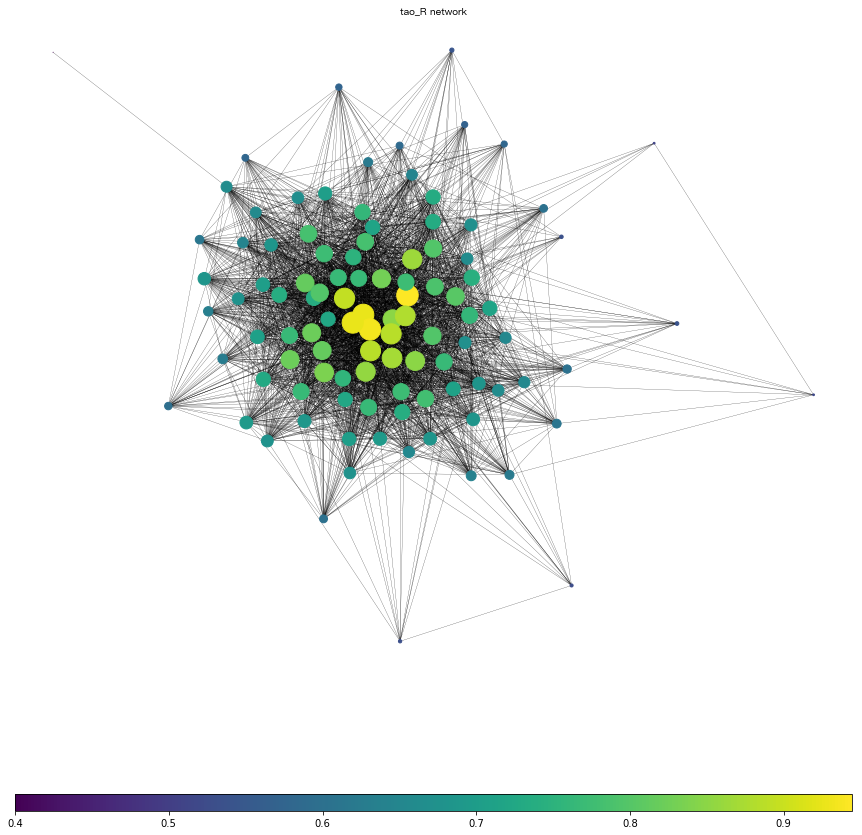

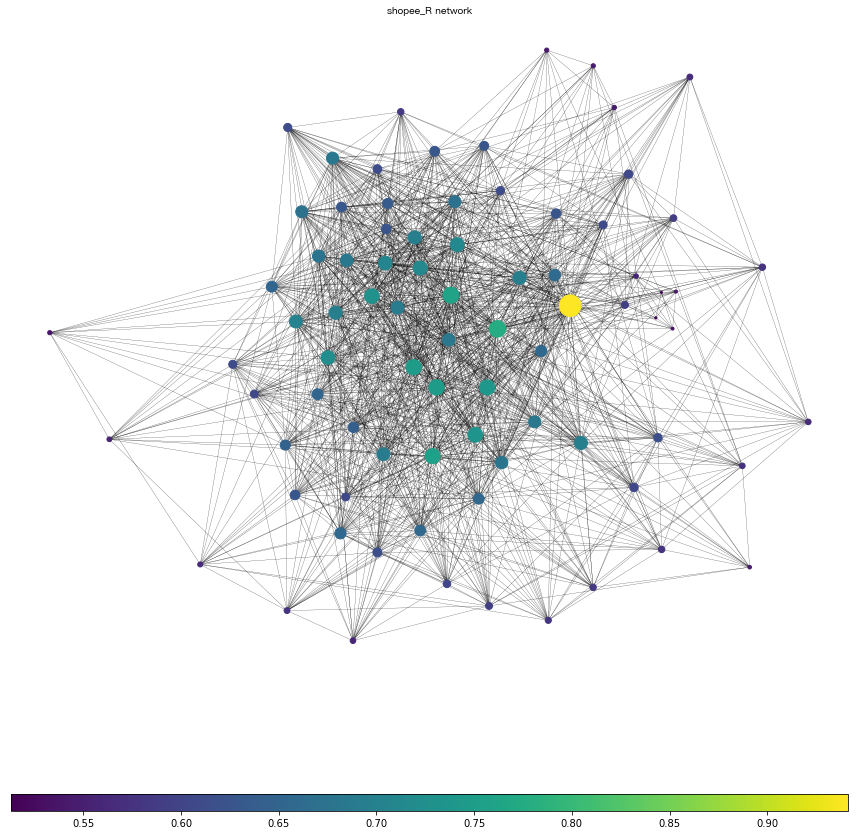

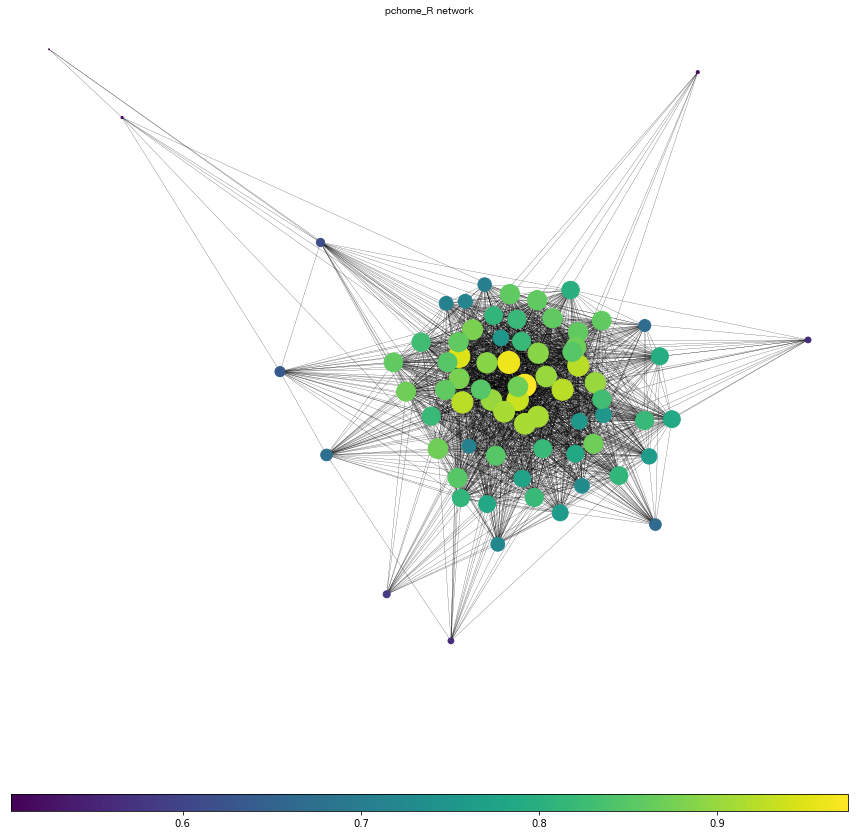

In [796]:
#loop一次畫好三個圖，然後把資料也丟出來整理好
cData_R = [] # 裡面是(tok, DC, CC)
wordCount = [] # 裡面是 node
for n, df in zip(name, all_tokR):
    df = df[['index', 'tok_R']]
    d,n =networkData(df, n+'_R',1/100)
    cData_R.append(d)
    wordCount.append(n)

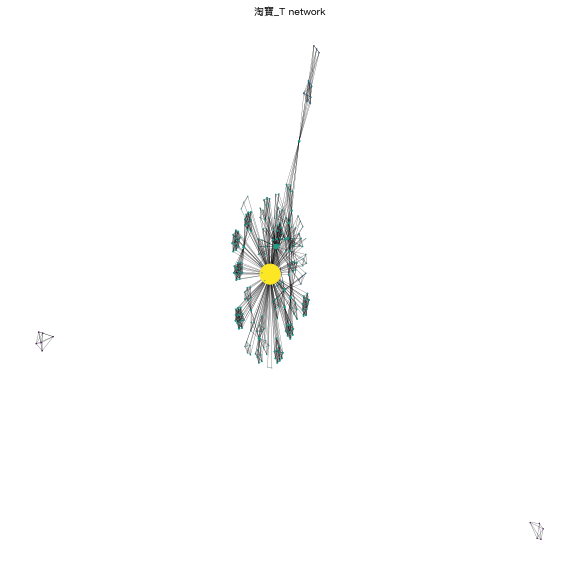

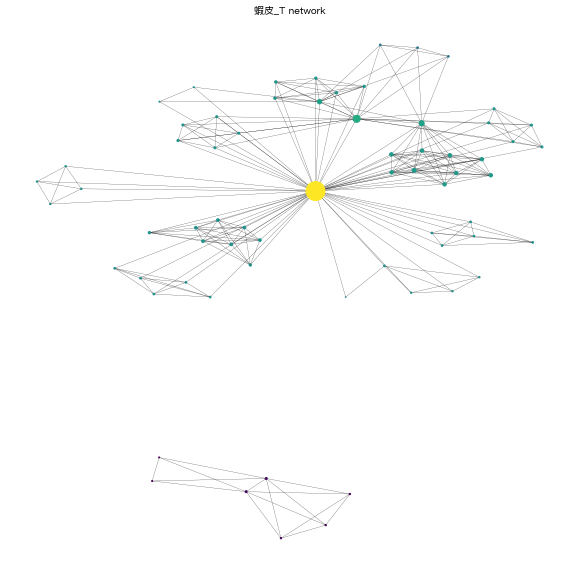

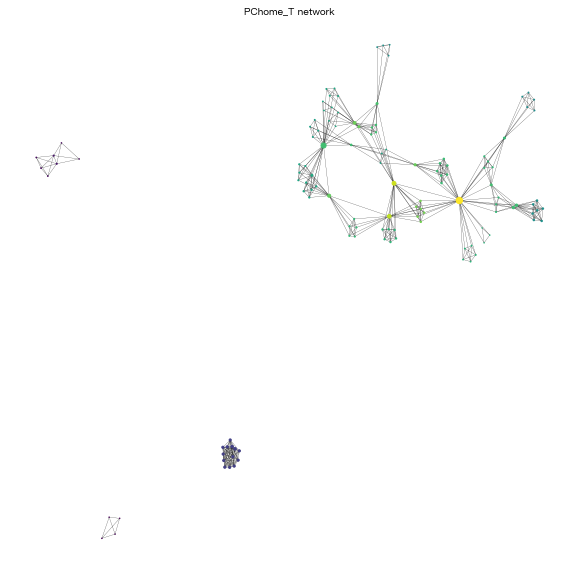

In [167]:
# 這個是標題（title）的圖(沒有用)
cData_T={}
for n, df in zip(name, all_tokTitle,):
    df = df[['index', 'tok_title']]
    cData_T[n]=networkData(df, n+'_T',0)[0]

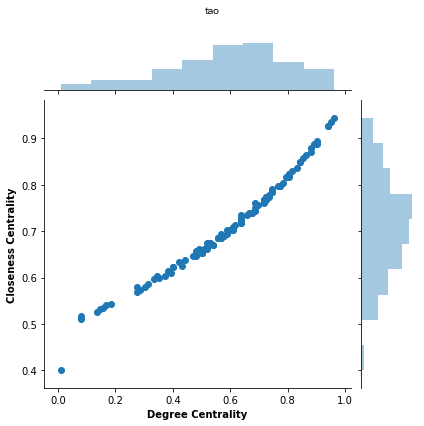

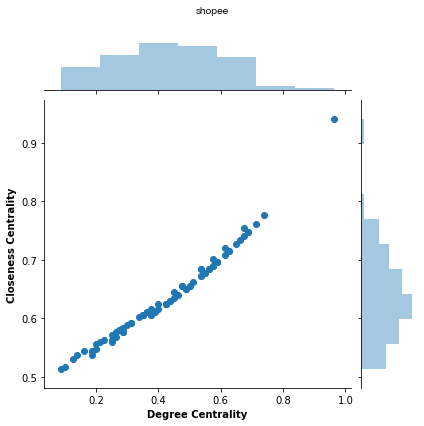

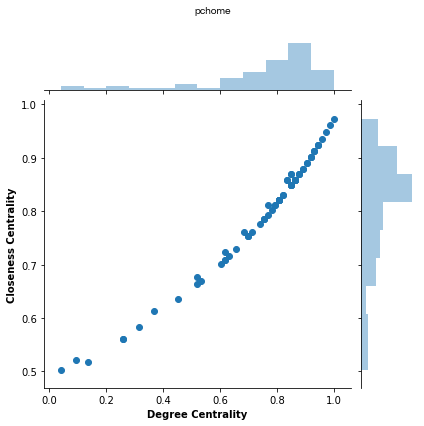

In [797]:
# 畫厲害的分配圖(有用)
def plotDist(data, pltTitle):
    myfont = FontProperties(fname=r'/System/Library/Fonts/PingFang.ttc')
    df = pd.DataFrame(data).set_index([0])
    df.rename(columns={1:'DC', 2:'CC'},inplace =True)
    p = sns.jointplot(x="DC", y="CC", data=df)
    p.ax_joint.set_xlabel('Degree Centrality', fontweight='bold')
    p.ax_joint.set_ylabel('Closeness Centrality', fontweight='bold')
    plt.subplots_adjust(top=0.9)
    plt.suptitle(pltTitle, fontproperties=myfont)
    
for d, n in zip(cData_R,name):
    plotDist(d, n)
    plt.savefig('%s dist.png'%n,bbox_inches="tight")

In [799]:
## 前十名的詞（有用）
wordCount2= []# <-最後會放在這
def fromNodeToCount(node_list):
    a=list(map(lambda x:(x[0], len(list(dict.fromkeys(x[1])))), node_list.items()))
    s = sorted(a,key=lambda x:x[1], reverse=True)
    return s

for i in wordCount:
    a= list(map(lambda x:(x[0], len(list(dict.fromkeys(x[1])))), i.items()))
    s = sorted(a,key=lambda x:x[1], reverse=True)
    wordCount2.append(s)
    

In [800]:
# 就是前十個字（好像前面寫了一樣的）
for i, n in zip(wordCount2, ['tao', 'shopee', 'PChome']):
    print(list(map(lambda x: x[0],i[0:11])))
    pd.DataFrame(list(map(lambda x:(x[1],x[0]),i))).to_csv(n+'.csv', index=None, sep=',')

['淘寶', '可以', '自己', '真的', '知道', '賣家', '沒有', '集運', '東西', '謝謝', '影片']
['蝦皮', 'momo', '評價', '番茄', '點數', '農來家', '星送', '購物車', '清空', '搶到', '免運']
['pchome', '蝦皮', '真的', 'pc', '可以', '免運', '還是', '東西', '就是', '這樣', '現在']


In [818]:
#前十個字的情緒（有用）

# 產生node--> {node:{正向：count, 負向＝count, 中立＝count}}
def toNode2(df):
    nodes ={}
    for tok_title in df.values.tolist(): 
        for tok in tok_title[1]:
            nodes.setdefault(tok, {}).setdefault(tok_title[0], []).append(1)
    for i in nodes.keys():
        for j in nodes[i].keys():
            nodes[i][j]=sum(nodes[i][j])
    return nodes

In [802]:
#整理好10個字的正負中情緒之後存成csv
for aa in range(3):
    tok = all_data[aa]
    tok['tok']=tok['內容'].map(lambda x: list(jieba.cut(x, cut_all=False)))
    a=toNode2(tok[['情緒標記', 'tok']])

    b={i[0]:a[i[0]] for i in wordCount2[aa][0:11]}
    c = pd.DataFrame(b)
    c=c.transpose()
    c['s'] =pd.DataFrame(b).sum()
    name =['tao','shopee','pchome']
    c.sort_values('s',ascending=False).to_csv(name[aa]+'_mod.csv')


# 社群網站在討論什麼(淘寶)？

In [803]:
# 標題的
k=0
d= all_data[k][all_data[k].來源=='社群網站'].drop_duplicates('標題')
#print(d.shape)
d.drop_duplicates(['標題'])[['標題','來源網站','討論串總則數']].sort_values(['討論串總則數','來源網站'],ascending=False).to_csv('discussion.csv')
d.insert(loc=0, column='index', value=np.arange(len(d)))
d['tok'] = d['標題'].map(lambda x:remove_useless(list(jieba.cut(x, cut_all=False))))
node, edge = nodeEdge(d[['index', 'tok']])
print(sorted(list(map(lambda x:(x[0],len(x[1])),node.items())), key=lambda x:x[1], reverse=True)[0:5])


[('淘寶', 16), ('開箱', 4), ('什麼', 3), ('遊戲', 2), ('申請', 2)]


In [804]:
# 內容的（沒用）
d2= all_data[k][all_data[k].來源=='社群網站']
#print(d.shape)
#print(d.drop_duplicates(['標題'])[['標題','來源網站']])
d2.insert(loc=0, column='index', value=np.arange(len(d2)))
d2['tok'] = d2['內容'].map(lambda x:remove_useless(list(jieba.cut(x, cut_all=False))))
node2, edge2 = nodeEdge(d2[['index', 'tok']])
print(sorted(list(map(lambda x:(x[0],len(x[1])),node2.items())), key=lambda x:x[1], reverse=True)[0:5])

[('可以', 47), ('淘寶', 45), ('影片', 41), ('分享', 38), ('喜歡', 34)]


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [808]:
# 討論區標題
k=2
d= all_data[k][all_data[k].來源=='討論區'].drop_duplicates('標題')
#print(d.shape)
d.drop_duplicates(['標題'])[['標題','來源網站','討論串總則數']].sort_values(['討論串總則數','來源網站'],ascending=False).to_csv('discussion.csv')
d.insert(loc=0, column='index', value=np.arange(len(d)))
d['tok'] = d['標題'].map(lambda x:remove_useless(list(jieba.cut(x, cut_all=False))))
node, edge = nodeEdge(d[['index', 'tok']])
print(sorted(list(map(lambda x:(x[0],len(x[1])),node.items())), key=lambda x:x[1], reverse=True)[0:5])

[('pchome', 6), ('情報', 6), ('PCHOME', 4), ('閒聊', 3), ('PChome', 3)]


# pchome vs shopee

In [810]:
k=2
d3= all_data[k]
d3['tok'] = d3['內容'].map(lambda x:remove_useless(list(jieba.cut(x, cut_all=False))))
d3.insert(loc=0, column='index', value=np.arange(len(d3)))
node, edge = nodeEdge(d3[['index', 'tok']])
list(edge.items())[0]

ll=['pchome','PChome','Pchome','商店街']
li=[]

for l in ll:
    try:
        li=li+edge[('蝦皮', l)]
    except:
        pass
ln=node['蝦皮']
li = list(dict.fromkeys(li))
list(dict.fromkeys(ln))
len(ln)


160

In [813]:
shopeeInPC = d3[d3.index.isin(li)]
node, edge = nodeEdge(shopeeInPC[['index', 'tok']])
print(list(x[0] for x in sorted(list(map(lambda x:(x[0],len(x[1])),node.items())), key=lambda x:x[1], reverse=True)[0:10]))

['蝦皮', '商店街', '網家', 'pchome', '露天', '供應商', '就是', '根本', '虧損', '財報']


In [814]:
k=2
d4= all_data[k].drop_duplicates('標題')
d4['tok'] = d4['標題'].map(lambda x:remove_useless(list(jieba.cut(x, cut_all=False))))
d4.head()
node, edge = nodeEdge(d4[['index', 'tok']])
list(edge.items())[0]

ll=['pchome','PChome','Pchome','商店街']
li=[]

for l in ll:
    try:
        li=li+edge[('蝦皮', l)]
    except:
        pass
    
ln=node['蝦皮']
shopeeInPC = d4[d4.index.isin(li)]
node, edge = nodeEdge(shopeeInPC[['index', 'tok']])
w = sorted(list(map(lambda x:(x[0],len(x[1])),node.items())), key=lambda x:x[1], reverse=True)[0:10]
list(map(lambda x:x[0], w))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


['蝦皮', '商店街', '去年', '每股', '大虧', '43.25', '新聞', '對決', '燒錢']

In [815]:
shopeeInPC['標題']

782    [新聞]跟蝦皮對決燒錢商店街去年每股大虧43.25
842         蝦皮害的？商店街去年每股大虧43.25元
Name: 標題, dtype: object

 # 以下的code都不知道在幹嘛

In [816]:
print(sorted(cData_T[name[0]], key=lambda x:x[1], reverse =True)[0:10])
sorted(cData_T[name[0]], key=lambda x:x[2], reverse =True)[0:10]

KeyError: 'tao'

In [145]:
list(map(lambda x:x*100,(1,2,3)))

[100, 200, 300]

In [ ]:
sorted(list(a.items()), key=lambda x:x[1] ,reverse=True)

In [ ]:
len(list(filter(lambda x:x[1]['count']>9, list(map(lambda x:(x[0], {'index':x[1], 'count':len(x[1])}),nodes1.items())))))
len(list(map(lambda x:(x[0], {'index':x[1], 'count':len(x[1])}),nodes1.items())))


# 貼文內容分析(針對三個平台，大家的感覺、意見是什麼）
主文內容（正負向/類型） --> 回文內容（正負相）
classification?
主要討論的字詞、主題等

# 其他

 比較分析？
 
 
 關聯分析(同一篇提到兩個以上的平台)？
 
 
 correlation?
 
 
 貼文數的時間變化？（通常是有活動？或是特殊日子（抽獎，免運）？節慶打折？）

In [14]:
print(all_dedup.columns)
all_data[2].head()
#soruce_type

Index(['標題', '內容', '來源', '來源網站', '主文/回文', '發佈時間', '討論串總則數', '點閱數', '分享/轉貼數',
       '作者', '正面強度', '負面強度', '情緒標記', '原始連結'],
      dtype='object')


,標題,內容,來源,來源網站,主文/回文,發佈時間,討論串總則數,點閱數,分享/轉貼數,作者,正面強度,負面強度,情緒標記,原始連結
0,#團購#七折#北緯23.5N#免運#pchome,+1,討論區,校園聊天-Dcard > 美妝,回文18,2018/01/06 00:19:26,64,0,0,長庚科技大學／F,0.0,0.0,中立,https://www.dcard.tw/f/makeup/p/228066344
1,#團購#七折#北緯23.5N#免運#pchome,+1,討論區,校園聊天-Dcard > 美妝,回文19,2018/01/06 00:34:13,64,0,0,淡江大學公共行政學系／F,0.0,0.0,中立,https://www.dcard.tw/f/makeup/p/228066344
2,#團購#七折#北緯23.5N#免運#pchome,+1,討論區,校園聊天-Dcard > 美妝,回文20,2018/01/06 00:34:19,64,0,0,銘傳大學會計學系／F,0.0,0.0,中立,https://www.dcard.tw/f/makeup/p/228066344
3,#團購#七折#北緯23.5N#免運#pchome,+1,討論區,校園聊天-Dcard > 美妝,回文21,2018/01/06 00:38:44,64,0,0,臺灣藝術大學／F,0.0,0.0,中立,https://www.dcard.tw/f/makeup/p/228066344
4,[情報]加Pchome官方帳號送$50元折價券,推:感謝分享～$9購入100D,討論區,Ptt > Lifeismoney,回文62,2018/01/06 01:00:00,74,0,0,humbug,12.5,0.0,正面,http://www.ptt.cc/bbs/Lifeismoney/M.1515137943...


In [60]:
Toa_raw.groupby(['點閱數', '來源網站']).size().reset_index(name='freq')
print(Toa_raw['來源'].unique())
tok = jieba.cut(Toa_raw[Toa_raw['來源網站'].str.contains('Dcard')]['內容'].iloc[1], cut_all=False)
[i for i in tok]

['社群網站' '討論區' '新聞']


<generator object Tokenizer.cut at 0x11425c830>

In [132]:

Toa_raw['發佈時間'].unique().size
Toa_raw['發佈時間'].str.split(' ',expand=True)[1].str.split(':',expand=True).groupby([0]).size()
#Toa_raw['發佈時間'].iloc[0]
Toa_raw[['標題','討論串總則數']].drop_duplicates()['討論串總則數'].sum()
Toa_raw.describe()

,討論串總則數,點閱數,分享/轉貼數,正面強度,負面強度
count,962.000000,962.000000,962.000000,962.000000,962.000000
mean,241.191268,59752.616424,0.168399,6.258836,3.796881
std,360.761795,179062.415728,4.125845,12.321977,8.757696
min,18.000000,0.000000,0.000000,0.000000,0.000000
25%,46.000000,0.000000,0.000000,0.000000,0.000000
50%,90.000000,0.000000,0.000000,0.000000,0.000000
75%,202.000000,2.000000,0.000000,8.675000,2.600000
max,1263.000000,752645.000000,124.000000,100.000000,100.000000


Text(0.5,0,'時間')

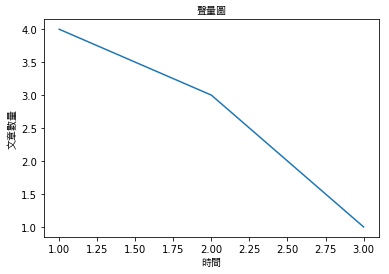

In [551]:

myfont = FontProperties(fname=r'/System/Library/Fonts/PingFang.ttc')
plt.plot((1,2,3),(4,3,1)) 
plt.title("聲量圖",fontproperties=myfont) 
plt.ylabel("文章數量",fontproperties=myfont) 
plt.xlabel("時間",fontproperties=myfont)  


In [740]:
print(wordCount[1]['番茄'])
all_tokR[1][all_tokR[1]['index'].isin(wordCount[1]['番茄'])]


[195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 225, 226, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 243, 244, 245, 246, 247, 248, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 276, 277, 278, 279, 280, 281, 284, 285, 286, 287, 288, 289, 291, 292, 293, 294, 295, 297, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 375, 381, 383, 389, 394, 396, 576, 629, 631, 632, 633, 634, 1113, 1139, 1145]


,index,標題,內容,tok_R
195,195,[自家] momo農家番茄寫蝦皮評價5星送openpoin!!,推: momo農來家番茄寫蝦皮評價5星送點數!!,"[momo, 農來家, 番茄, 蝦皮, 評價, 星送, 點數]"
196,196,[自家] momo農家番茄寫蝦皮評價5星送openpoin!!,推: momo農來家番茄寫蝦皮評價5星送點數!!,"[momo, 農來家, 番茄, 蝦皮, 評價, 星送, 點數]"
197,197,[自家] momo農家番茄寫蝦皮評價5星送openpoin!!,推: momo農來家番茄寫蝦皮評價5星送點數！！,"[momo, 農來家, 番茄, 蝦皮, 評價, 星送, 點數]"
198,198,[自家] momo農家番茄寫蝦皮評價5星送openpoin!!,推: momo農來家番茄寫蝦皮評價5星送點數!!,"[momo, 農來家, 番茄, 蝦皮, 評價, 星送, 點數]"
199,199,[自家] momo農家番茄寫蝦皮評價5星送openpoin!!,推: momo農來家番茄寫蝦皮評價5星送點數!!,"[momo, 農來家, 番茄, 蝦皮, 評價, 星送, 點數]"
200,200,[自家] momo農家番茄寫蝦皮評價5星送openpoin!!,推: momo農來家番茄寫蝦皮評價5星送點數!!,"[momo, 農來家, 番茄, 蝦皮, 評價, 星送, 點數]"
201,201,[自家] momo農家番茄寫蝦皮評價5星送openpoin!!,推: momo農來家番茄寫蝦皮評價5星送點數!!,"[momo, 農來家, 番茄, 蝦皮, 評價, 星送, 點數]"
202,202,[自家] momo農家番茄寫蝦皮評價5星送openpoin!!,推: momo農來家番茄寫蝦皮評價5星送點數!!,"[momo, 農來家, 番茄, 蝦皮, 評價, 星送, 點數]"
203,203,[自家] momo農家番茄寫蝦皮評價5星送openpoin!!,推: momo農來家番茄寫蝦皮評價5星送點數!!,"[momo, 農來家, 番茄, 蝦皮, 評價, 星送, 點數]"
204,204,[自家] momo農家番茄寫蝦皮評價5星送openpoin!!,推: momo農來家番茄寫蝦皮評價5星送點數!!,"[momo, 農來家, 番茄, 蝦皮, 評價, 星送, 點數]"


In [779]:
sorted(cData_R[2], key=lambda x:x[1],reverse = True)[0:15]

[('可以', 0.9863013698630136, 0.9605263157894737),
 ('還是', 0.9863013698630136, 0.9605263157894737),
 ('蝦皮', 0.9863013698630136, 0.9605263157894737),
 ('就是', 0.958904109589041, 0.9358974358974359),
 ('真的', 0.958904109589041, 0.9358974358974359),
 ('東西', 0.958904109589041, 0.9358974358974359),
 ('商店街', 0.958904109589041, 0.9358974358974359),
 ('現在', 0.9452054794520548, 0.9240506329113924),
 ('商品', 0.9452054794520548, 0.9240506329113924),
 ('台灣', 0.9315068493150684, 0.9125),
 ('很多', 0.9315068493150684, 0.9125),
 ('知道', 0.9178082191780821, 0.9012345679012346),
 ('結果', 0.9178082191780821, 0.9012345679012346),
 ('因為', 0.9041095890410958, 0.8902439024390244),
 ('PCHOME', 0.9041095890410958, 0.8902439024390244)]

In [819]:
for aa in range(3):
    tok = all_data[aa]
    tok['tok']=tok['內容'].map(lambda x: list(jieba.cut(x, cut_all=False)))
    a=toNode2(tok[['情緒標記', 'tok']])
    b={i[0]:a[i[0]] for i in sorted(cData_R[aa], key=lambda x:x[1],reverse = True)[0:10]}
    c = pd.DataFrame(b)
    c=c.transpose()
    c['s'] =pd.DataFrame(b).sum()
    name =['tao','shopee','pchome']
    c.sort_values('s',ascending=False).to_csv(name[aa]+'_mod_DC.csv')
    

In [820]:
list(filter(lambda x: x[0] in ['pchome','PChome','Pchome','PCHOME'], cData_R[2]))

[('pchome', 1.0, 0.9733333333333334)]

In [782]:
'你'.lower()=='你'

True